In [179]:
import wellmap
import pandas as pd
import os
import string
import seaborn as sns
from os import listdir
from os.path import isfile, join

New for multiple images in CP file

In [180]:
part_to_folder = r"C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-24 Vero Rd hTERT CK-99c ISK-1 Slovesnova"

# files = [f for f in listdir(part_to_folder) if isfile(join(part_to_folder, f))]

image_list_path = os.path.join(part_to_folder, "ExpImage.csv")
data_path  = os.path.join(part_to_folder, "ExpWells_plate.csv")

data_raw_df = pd.read_csv(data_path) 
image_list_df = pd.read_csv(image_list_path) 

print(image_list_df)


                                    FileName_RGB  ImageNumber
0     2024-07-19 RD CK-122 5H (Multichannel).tif            1
1   2024-07-19 Vero CK-122 5H (Multichannel).tif            2
2  2024-07-19 hTERT CK-122 5H (Multichannel).tif            3


Extract wellmaps and combine into one df with names of the images

In [181]:
wellmap_path_list = []

for file in os.listdir(part_to_folder):
    if file.endswith(".toml"):
        wellmap_path_list.append(os.path.join(part_to_folder, file))
        # wellmap_path_list.append(file)

print(wellmap_path_list[0])

wellmap_df = wellmap.load(wellmap_path_list[0]) 

wellmap_list = []

for file in wellmap_path_list:
    wellmap_i = wellmap.load(file)
    wellmap_list.append(wellmap_i)

wellmaps_df = pd.concat(wellmap_list, axis=0, ignore_index=True)
print(wellmaps_df)

C:\Users\Modern\Documents\Biorad\CellProfiler\Results\2024-07-19 RD, Vero, hTERT CK-122\2024-07-19 hTERT CK-122 5H (Multichannel).toml
    well well0 row col  row_i  col_j blank conc_uM  cells  uv RZ_incubation  \
0     A1   A01   A   1      0      0   Yes     100  hTERT  No            5H   
1     H1   H01   H   1      7      0   Yes     100  hTERT  No            5H   
2    A12   A12   A  12      0     11   Yes       0  hTERT  No            5H   
3    H12   H12   H  12      7     11   Yes       0  hTERT  No            5H   
4     A2   A02   A   2      0      1    No      50  hTERT  No            5H   
..   ...   ...  ..  ..    ...    ...   ...     ...    ...  ..           ...   
283   H7   H07   H   7      7      6    No     2.5   Vero  No            5H   
284   H8   H08   H   8      7      7    No       1   Vero  No            5H   
285   H9   H09   H   9      7      8    No     0.5   Vero  No            5H   
286  H10   H10   H  10      7      9    No    0.25   Vero  No            5H

Generating labels for wells

In [182]:
# row_column_df = pd.DataFrame(columns=['row','col'])

row =  list(string.ascii_uppercase[0:8])
column = list(range(1,13))
plate = image_list_df['FileName_RGB'].to_list()

row_column_list = []


for p in plate:
    for c in column:
        for r in row:
            array_i = [r,c]
            row_column_list.append(array_i)

row_column_df = pd.DataFrame(row_column_list, columns = ['row', 'col']) 

print(row_column_df)

    row  col
0     A    1
1     B    1
2     C    1
3     D    1
4     E    1
..   ..  ...
283   D   12
284   E   12
285   F   12
286   G   12
287   H   12

[288 rows x 2 columns]


Add images names to data (thank you CellProfiler for convenience)

In [183]:
data_full_df =  pd.merge(data_raw_df, image_list_df, on='ImageNumber') #Data with image names (FileName_RGB)
data_indexed = pd.concat([row_column_df, data_full_df], axis=1, join='inner') #Data with image names (FileName_RGB) and cell indexes (row,col)

data_indexed['col']=data_indexed['col'].astype(str) #Otherwise everything will break

data_plate = pd.merge(data_indexed, wellmaps_df, on=['FileName_RGB','row','col']) #Data with image names (FileName_RGB), cell indexes and wellmap
data_plate[["conc_uM"]] = data_plate[["conc_uM"]].apply(pd.to_numeric)

print(data_plate.columns)

Index(['row', 'col', 'ImageNumber', 'ObjectNumber',
       'Intensity_IntegratedIntensity_OrigGreen',
       'Intensity_IntegratedIntensity_OrigRed',
       'Intensity_MeanIntensity_OrigGreen', 'Intensity_MeanIntensity_OrigRed',
       'Intensity_StdIntensity_OrigGreen', 'Intensity_StdIntensity_OrigRed',
       'FileName_RGB', 'well', 'well0', 'row_i', 'col_j', 'blank', 'conc_uM',
       'cells', 'uv', 'RZ_incubation', 'substance_incubation', 'culture_type'],
      dtype='object')


Blank and control calculation for each plate

In [184]:
blank_control_array = []

for p in plate:
    blank_p = data_plate[(data_plate['blank'] == 'Yes') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    control_p = data_plate[(data_plate['conc_uM'] == 0) & (data_plate['blank'] == 'No') & (data_plate['FileName_RGB'] == p)].loc[:,'Intensity_MeanIntensity_OrigGreen'].mean()
    bc_array_i = [blank_p,control_p,p]

    blank_control_array.append(bc_array_i)


blank_control_df = pd.DataFrame(blank_control_array, columns = ['blank_mean', 'control_mean','FileName_RGB']) 

print(blank_control_df)




   blank_mean  control_mean                                   FileName_RGB
0    0.016522      0.159803     2024-07-19 RD CK-122 5H (Multichannel).tif
1    0.016847      0.185633   2024-07-19 Vero CK-122 5H (Multichannel).tif
2    0.016797      0.143161  2024-07-19 hTERT CK-122 5H (Multichannel).tif


Blank exclusion and relative values calculating

In [185]:
data_plate_wo_blank_wells = data_plate[data_plate.blank == 'No'].copy() #dataframe without blank

data_plate_with_mean_blank_control = pd.merge(data_plate_wo_blank_wells, blank_control_df, on=['FileName_RGB'])

data_plate_with_mean_blank_control['Green_blanked'] = data_plate_with_mean_blank_control['Intensity_MeanIntensity_OrigGreen'] - data_plate_with_mean_blank_control['blank_mean']
data_plate_with_mean_blank_control['Green_relative'] = data_plate_with_mean_blank_control['Green_blanked']/data_plate_with_mean_blank_control['control_mean']*100

Plotting


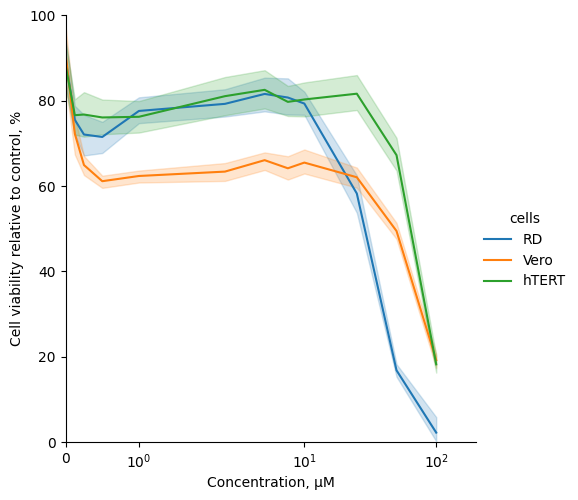

: 

In [188]:
ax = sns.relplot(data=data_plate_with_mean_blank_control, x="conc_uM", y="Green_relative", kind="line", hue = 'cells')


# ax.set(xlabel=None, ylabel='Viable cell, % of control')

ax.set(xlabel='Concentration, μM', ylabel='Cell viability relative to control, %')
ax.set(xscale="symlog")

ax.set(xlim=(0, 200),ylim = (0,100))



C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Modern\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[(-1.0, 110.0)]

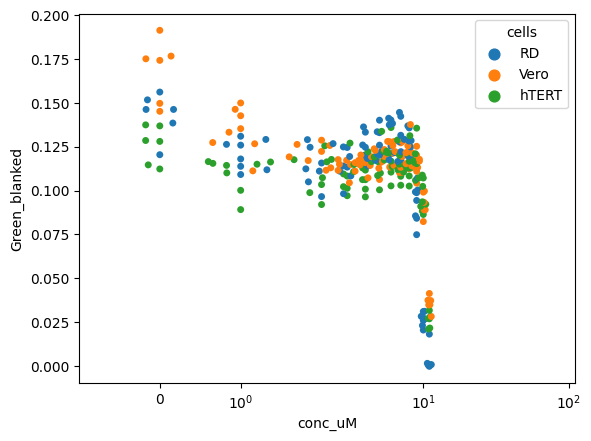

In [178]:
ax = sns.swarmplot(data=data_plate_with_mean_blank_control, x="conc_uM", y="Green_blanked", hue = 'cells')
ax.set(xscale="symlog")
ax.set(xlim=(-1, 110))
